# Introduction 
Following through [this excellent tutorial](https://rpubs.com/adam_dennett/257231) by Adam Dennett on geospatial flow modelling. The focus of this notebook is:
- Getting and cleaning data on commuter flows from StatsNZ
- Plotting the flow data onto the territorial authorities map for Wellington
- Findng the data equivalents used in the RPubs analysis for Wellington 
- Presenting and understanding the basic unconstrained model of spatial flows

# Package installation
I'm working from a Ubuntu 18.04 VM on Windows. I needed to install a bunch of additional linux packages for the necessary R libraries and their dependencies:
- sudo apt  install protobuf-compiler
- sudo apt install libprotobuf-dev
- sudo apt install libv8-3.14-dev
- sudo apt-get install libjq-dev
- sudo apt install libudunits2-dev
- sudo apt install libgdal-dev
- sudo apt install libgdal1-dev (though I'm not 100% sure of this one)


In [22]:
library(sp);
library(MASS);
library(reshape2);
library(geojsonio);
library(rgdal);
library(downloader);
library(maptools);
library(dplyr);
library(broom); 
library(stplanr);
library(ggplot2);
library(leaflet);

# Data extraction
Commuter flows from the NZ census are not available in a handy tabular format. But StatsNZ have provided a [Beta version of a commuter flow interactive map](https://www.stats.govt.nz/tools/commuter-view). I manually downloaded the flow data for each of the wards within the Wellington City territorial authority. The data is limited because the Wellington City TA doesn't capture the Hutt Valley or Porirua - two key suburban areas of the Greater Wellington region. Once I have a basic version of the model running, I'll extract the complete dataset. 

## Flow data

In [23]:
df <- read.csv("data/commuter_flow_wellington_city.csv")
colnames(df) <- c('to_code', 'to_name', 'flow_type', 'year_2006', 'year_2013', 'from_code', 'from_name')
df$year_2006 <- as.numeric(as.character(df$year_2006));
df$year_2013 <- as.numeric(as.character(df$year_2013));

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [16]:
df_clean <- df %>% filter(to_name %in% from_name) %>% filter(flow_type == 'in')
df_clean %>% head()

to_code,to_name,flow_type,year_2006,year_2013,from_code,from_name
576500,Adelaide,in,0,0,576500,Adelaide
573200,Aro Street-Nairn Street,in,42,33,576500,Adelaide
574401,Awarua,in,24,36,576500,Adelaide
576302,Berhampore East,in,30,39,576500,Adelaide
576200,Berhampore West,in,60,84,576500,Adelaide
575600,Brooklyn,in,45,81,576500,Adelaide


In [20]:
df_matrix <- dcast(df_clean,
                   from_name ~ to_name,
                   sum,
                   value.var = "year_2013",
                   margins=c("from_name", "to_name"))


In [21]:
df_matrix %>% head()

from_name,Adelaide,Aro Street-Nairn Street,Awarua,Berhampore East,Berhampore West,Brooklyn,Brooklyn South,Churton Park North,Churton Park South,⋯,Tawa South,Te Kainga,Thorndon-Tinakori Road,Vogeltown,Vogeltown West,Wadestown,Willis Street-Cambridge Terrace,Wilton,Woodridge,(all)
Adelaide,0,33,36,39,84,81,21,27,51,⋯,30,45,33,36,12,45,84,27,24,3300
Aro Street-Nairn Street,0,0,0,0,0,12,0,0,0,⋯,0,6,0,0,0,0,0,0,0,69
Awarua,0,0,0,0,0,0,0,0,0,⋯,0,6,0,0,0,0,0,0,0,6
Berhampore West,0,0,0,9,0,0,0,0,0,⋯,0,0,0,0,0,0,6,0,0,129
Brooklyn,0,0,0,0,0,0,12,0,0,⋯,0,0,0,0,9,0,6,0,0,81
Churton Park North,0,0,0,0,0,0,0,0,24,⋯,0,0,0,0,0,0,0,0,0,48


## Features by TA wards

In [37]:
income_df <- read.csv("data//wellington-city-ta-personal-income-bracket.csv", sep=';')
income_df <- tibble::rownames_to_column(income_df)

In [38]:
income_df %>% head()

rowname,ward,Total.people..total.personal.income,Loss,Zero.income,X.1..5.000,X.5.001..10.000,X.10.001..15.000,X.15.001..20.000,X.20.001..25.000,⋯,X.30.001..35.000,X.35.001..40.000,X.40.001..50.000,X.50.001..60.000,X.60.001..70.000,X.70.001..100.000,X.100.001..150.000,X.150.001.or.more,Total.people.stated,Not.stated
Tawa South,NA,2838,6,192,192,132,183,195,180,⋯,120,111,237,216,153,333,216,90,2676,159
Tawa Central,NA,3444,9,282,207,150,213,261,222,⋯,165,174,321,267,219,372,156,42,3231,213
Linden,NA,3123,18,285,204,174,201,231,186,⋯,144,180,294,222,183,246,117,42,2883,240
Greenacres,NA,1239,0,102,75,60,63,66,63,⋯,45,48,111,105,75,177,84,39,1182,54
Thorndon-Tinakori Road,NA,3804,12,141,162,156,195,195,153,⋯,135,165,369,348,267,522,312,255,3543,261
Lambton,NA,5451,24,405,762,573,420,258,216,⋯,171,195,387,339,222,420,282,159,4989,462


In [156]:
factorToNum <- function(x){
    y <- as.numeric(as.character(x))
    return(y)
}


income_vals <- income_df[,5:19]
salary_levels <- colnames(income_vals)
income_vals <- as.data.frame(sapply( income_vals, factorToNum ));
income_vals$statistical_area <- income_df$rowname
people <-  income_df[, 20];
people <- as.data.frame(sapply(people, factorToNum));
colnames(people) <- c('total')
people$statistical_area <- income_df$rowname

Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[

In [126]:
income_mid <- c(0, seq(2500, 40000, 5000), seq(45000, 70000, 10000), 90000, 125000, 200000)
income_mid
income_numeric <- as.data.frame(income_mid)
income_numeric$salary_levels <- salary_levels
income_numeric

[1]      0   2500   7500  12500  17500  22500  27500  32500  37500  45000
[11]  55000  65000  90000 125000 200000

income_mid,salary_levels
0,Zero.income
2500,X.1..5.000
7500,X.5.001..10.000
12500,X.10.001..15.000
17500,X.15.001..20.000
22500,X.20.001..25.000
27500,X.25.001..30.000
32500,X.30.001..35.000
37500,X.35.001..40.000
45000,X.40.001..50.000


In [157]:
income_by_statistical_area<- melt(income_vals)
income_by_statistical_area <- inner_join(income_by_statistical_area, income_numeric, by = c("variable" = "salary_levels"))

Using statistical_area as id variables
Warning message:
“Column `variable`/`salary_levels` joining factor and character vector, coercing into character vector”

In [159]:
income_by_statistical_area %>% 
group_by(statistical_area) %>% 
summarise(total_calc_income = sum(value * income_mid)) %>% 
inner_join(people) %>% 
mutate(median_calc_income = total_calc_income / total) %>% 
arrange(desc(median_calc_income)) %>%
head()

Joining, by = "statistical_area"


statistical_area,total_calc_income,total,median_calc_income
Kaiwharawhara,10327500,117,88269.23
Wadestown,198255000,2661,74503.95
Oriental Bay,67785000,915,74081.97
Te Kainga,212250000,2877,73774.77
Seatoun,116887500,1602,72963.48
Karaka Bay-Worser Bay,79275000,1104,71807.07


# Geolocation data
+proj=nzmg +lat_0=-41 +lon_0=173 +x_0=2510000 +y_0=6023150 +datum=nzgd49 +units=m +no_defs


In [160]:
library(sf)

Linking to GEOS 3.6.2, GDAL 2.2.3, proj.4 4.9.3


In [244]:
wgtn_bdry <- read_sf("./data/wgtn-stat-area-2/AU_TA_Wellington_CC.shp")

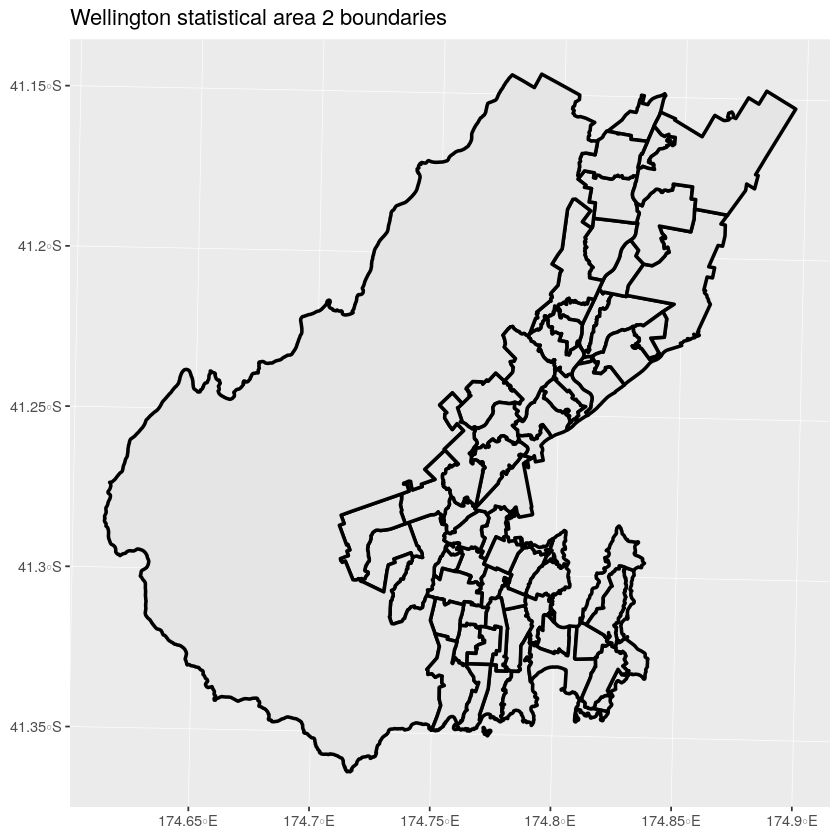

In [245]:
ggplot() + 
  geom_sf(data = wgtn_bdry, size = 1, color = "black") + 
  ggtitle("Wellington statistical area 2 boundaries")

In [196]:
str(wgtn_bdry)

Classes ‘sf’, ‘tbl_df’, ‘tbl’ and 'data.frame':	68 obs. of  6 variables:
 $ UID_AU_TA: chr  "573800|047" "573900|047" "573523|047" "573400|047" ...
 $ AU_NO    : chr  "573800" "573900" "573523" "573400" ...
 $ TA_NO    : chr  "047" "047" "047" "047" ...
 $ AU_NAME  : chr  "Johnsonville East" "Newlands North" "Grenada Village" "Mt Victoria West" ...
 $ TA_NAME  : chr  "Wellington City" "Wellington City" "Wellington City" "Wellington City" ...
 $ geometry :sfc_MULTIPOLYGON of length 68; first list element: List of 1
  ..$ :List of 1
  .. ..$ : num [1:108, 1:2] 2662710 2662578 2662601 2662599 2662587 ...
  ..- attr(*, "class")= chr  "XY" "MULTIPOLYGON" "sfg"
 - attr(*, "sf_column")= chr "geometry"
 - attr(*, "agr")= Factor w/ 3 levels "constant","aggregate",..: NA NA NA NA NA
  ..- attr(*, "names")= chr  "UID_AU_TA" "AU_NO" "TA_NO" "AU_NAME" ...


## Read data as a spatial polygons dataframe

In [243]:
library(rgdal)
wgtn <- readOGR("./data/wgtn-stat-area-2", layer="AU_TA_Wellington_CC")

OGR data source with driver: ESRI Shapefile 
Source: "/home/shrividya/Documents/wellington-commutes/data/wgtn-stat-area-2", layer: "AU_TA_Wellington_CC"
with 68 features
It has 5 fields


In [220]:
wgtn

class       : SpatialPolygonsDataFrame 
features    : 68 
extent      : 2645098, 2669062, 5981296, 6005477  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=nzmg +lat_0=-41 +lon_0=173 +x_0=2510000 +y_0=6023150 +datum=nzgd49 +units=m +no_defs +ellps=intl +towgs84=59.47,-5.04,187.44,0.47,-0.1,1.024,-4.5993 
variables   : 5
names       :  UID_AU_TA,  AU_NO, TA_NO,      AU_NAME,         TA_NAME 
min values  : 572500|047, 572500,   047,     Adelaide, Wellington City 
max values  : 577700|047, 577700,   047, Wilton-Otari, Wellington City 

In [225]:
summary(wgtn)

Object of class SpatialPolygonsDataFrame
Coordinates:
      min     max
x 2645098 2669062
y 5981296 6005477
Is projected: TRUE 
proj4string :
[+proj=nzmg +lat_0=-41 +lon_0=173 +x_0=2510000 +y_0=6023150
+datum=nzgd49 +units=m +no_defs +ellps=intl
+towgs84=59.47,-5.04,187.44,0.47,-0.1,1.024,-4.5993]
Data attributes:
  UID_AU_TA            AU_NO           TA_NO      AU_NAME         
 Length:68          Length:68          047:68   Length:68         
 Class :character   Class :character            Class :character  
 Mode  :character   Mode  :character            Mode  :character  
            TA_NAME  
 Wellington City:68  
                     
                     

In [224]:
wgtn$AU_NAME <- as.character(wgtn$AU_NAME)
wgtn$AU_NO <- as.character(wgtn$AU_NO)
wgtn$UID_AU_TA <- as.character(wgtn$UID_AU_TA)

In [239]:
# Names dataframe
names <- as.data.frame(wgtn$AU_NAME)
names$num <- seq(1, nrow(names))

# Calculate and tabulate pairwise distances
df_distance <- melt(spDists(wgtn))

# Clean up pairwise distance dataframe
df_distance <- inner_join(df_distance, names, by=c("Var1"= "num"))
df_distance <- inner_join(df_distance, names, by=c("Var2"= "num"))
colnames(df_distance) <- c('Var1', 'Var2', 'distance', 'from', 'to')

# Look at pairwise distances
df_distance %>% head()

Var1,Var2,distance,from,to
1,1,0.0000,Johnsonville East,Johnsonville East
2,1,1022.0800,Newlands North,Johnsonville East
3,1,1933.2139,Grenada Village,Johnsonville East
4,1,8982.8839,Mt Victoria West,Johnsonville East
5,1,687.4492,Johnsonville North,Johnsonville East
6,1,1009.8422,Johnsonville South,Johnsonville East
